In [1]:
import numpy as np
import pandas as pd
import dill as pickle

%load_ext autoreload
%autoreload 1
%aimport CodingFeatures
%aimport CodingTransformers

In [2]:
with open('../data/GENOME_K12-MG1655.txt','r') as f:
    seq_raw = f.readlines()
seq_raw = [x.strip() for x in seq_raw]
seq_raw = ''.join(seq_raw)

## Import and initialize genome data and reference tables

In [3]:
from CodingFeatures import codon_lookup

codon_table, c_lookup = codon_lookup()
AA_list = codon_table['aa'].unique()[1:]

In [7]:
from CodingFeatures import DNAAttributeConstruction, fragment_stop_delimited, fragment_windowed

genome_object = DNAAttributeConstruction(seq_raw).decode_dna(c_lookup)

## Feature extraction and model predictions

In [8]:
with open('../models/FU_v01a.pkl','rb') as f:
    FU = pickle.load(f)

with open('../models/RFCmodel_v01a.pkl','rb') as f:
    model = pickle.load(f)

In [9]:
genome_features = FU.transform(genome_object)

In [10]:
with open('../models/features_genome_v01a.pkl','wb') as f:
    pickle.dump(genome_features,f)

In [ ]:
with open('../models/features_genome_v01a.pkl','rb') as f:
    genome_features = pickle.load(f)

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
results = pd.DataFrame(genome_object.frag_index, columns=['idg', 'idn'])
results['seq_frag'] = genome_object.fragments
results['end_frag'] = results.idn + results.seq_frag.map(len)
results['predict'] = model.predict(genome_features)

In [13]:
from CodingFeatures import seq_merge

summary = pd.DataFrame()
summary['start'] = results.idn.groupby(results.idg).min()
summary['end'] = results.end_frag.groupby(results.idg).max()
summary['avg_score'] = results.predict.groupby(results.idg).mean()
summary['n_windows'] = results.predict.groupby(results.idg).count()
summary['seq'] = results.seq_frag.groupby(results.idg).apply(seq_merge)

stat_pos, stat_tot = summary[summary.avg_score >= .5].avg_score.count(), summary.shape[0]

In [15]:
summary.to_csv('../output/genome_predictions_v01a.csv')

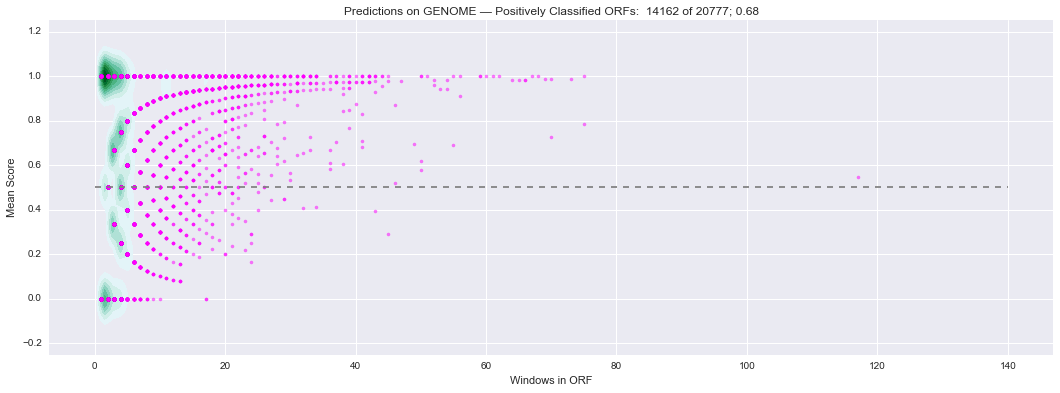

In [16]:
fig,ax = plt.subplots(figsize=(18,6))
ax.set_title('Predictions on GENOME — Positively Classified ORFs:  {0} of {1}; {2:.{3}f}'.format(stat_pos,stat_tot,stat_pos/stat_tot,2))
ax.set_xlabel('Windows in ORF')
ax.set_ylabel('Mean Score')
ax.hlines(.5,0,140,linestyles='dashed', color='grey')
sns.kdeplot(summary[['n_windows','avg_score']], shade=True, shade_lowest=False, ax=ax)
ax.scatter(summary.n_windows, summary.avg_score, color='magenta', alpha=.5, s=10)

In [17]:
print(results.columns)
print(summary.columns)

Index(['idg', 'idn', 'seq_frag', 'end_frag', 'predict'], dtype='object')
Index(['start', 'end', 'avg_score', 'n_windows', 'seq'], dtype='object')


In [18]:
# get annotated protein sequences
annotated = pd.read_csv('../data/BW25113proteome_dnaseq.csv') # get full sheet
annotated = annotated.drop_duplicates('seq').dropna() # drop duplicated proteins and missing DNA_seq
annotated['DNA_seq'] = annotated['DNA_seq'].apply(lambda x: x[3:]) # trim start codons from DNA_seq
annotated['start'] = annotated['start'] + 3 # increment sequence location index
